In [ ]:
# Neural Style Transfer (NST) Implementation

## **Project Overview**
This notebook demonstrates the implementation of **Neural Style Transfer (NST)** using TensorFlow and a pretrained VGG19 model. Neural Style Transfer is a technique that combines the **content** of one image with the **style** of another to generate a new image that looks like the first image was painted in the style of the second.

---

## **Purpose**
This notebook is part of the CodTech internship task to create a Python script or notebook that applies artistic styles to photographs using deep learning techniques. Upon successful completion, a styled image will be generated, combining the features of both a content image and a style image.

---

## **Contents**
1. **Introduction**:
   - Brief explanation of NST and the goal of this notebook.

2. **Setup**:
   - Installation of necessary libraries.
   - Loading the content and style images.

3. **Model**:
   - Use of the VGG19 pretrained model for feature extraction.

4. **Loss Functions**:
   - Content loss: Preserves the content of the original image.
   - Style loss: Captures the artistic essence of the style image.

5. **Training**:
   - Optimization process to generate the final styled image.

6. **Output**:
   - Display of the original content and style images.
   - The final styled image generated through the NST process.

---

## **How to Use This Notebook**
1. Replace the file paths in `content_path` and `style_path` with the paths to your content and style images.
2. Run each cell sequentially to process the images, train the model, and generate the output.
3. Enjoy the result and feel free to tweak the parameters for different outcomes!

---

## **Acknowledgments**
This implementation uses TensorFlow and a pretrained VGG19 model. The architecture is adapted for artistic style transfer as described in the paper **"A Neural Algorithm of Artistic Style"** by Gatys et al.

---

**Let’s get started!** 🎨


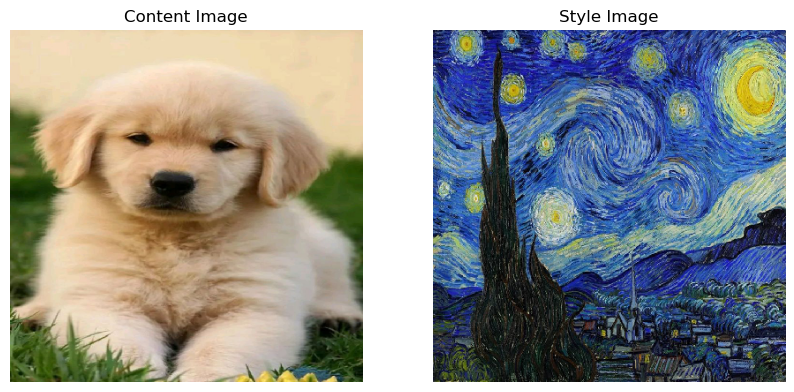

Epoch 0, Loss: 4.299319815857766e+16
Epoch 100, Loss: 3.724206515054182e+16
Epoch 200, Loss: 3.2274505975988224e+16
Epoch 300, Loss: 2.777939749896192e+16
Epoch 400, Loss: 2.412484418653389e+16
Epoch 500, Loss: 2.1281384710537216e+16
Epoch 600, Loss: 1.9076747932729344e+16
Epoch 700, Loss: 1.7361633273708544e+16
Epoch 800, Loss: 1.6010989539426304e+16
Epoch 900, Loss: 1.4938585597739008e+16


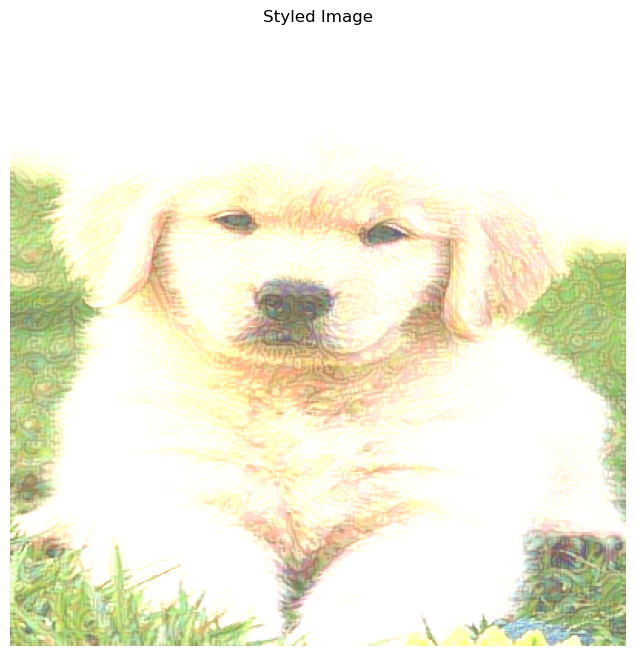

In [8]:
# Install required libraries
!pip install tensorflow matplotlib numpy

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Function to load and preprocess images
def load_and_process_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess images for visualization
def deprocess_image(img):
    img = img[0]
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Load content and style images
content_path = r"C:\Users\saikiran\Code tech tasks\cute pet1.jpg"
style_path = r"C:\Users\saikiran\Code tech tasks\painting.jpg"

content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

# Display the input images
def display_images(content, style):
    content_img = deprocess_image(content)
    style_img = deprocess_image(style)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Content Image")
    plt.imshow(content_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Style Image")
    plt.imshow(style_img)
    plt.axis('off')
    plt.show()

display_images(content_image, style_image)

# Define VGG19 model for feature extraction
def get_model():
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = [
        'block1_conv1', 'block2_conv1',
        'block3_conv1', 'block4_conv1', 'block5_conv1'
    ]
    content_outputs = [vgg.get_layer(layer).output for layer in content_layers]
    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
    model_outputs = content_outputs + style_outputs
    return Model(vgg.input, model_outputs), content_layers, style_layers

model, content_layers, style_layers = get_model()

# Define loss functions for content and style
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    vectorized = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(vectorized), vectorized)
    return gram

def compute_style_loss(base_style, target_gram):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - target_gram))

# Define the total loss function
def compute_loss(model, content_image, style_image, generated_image):
    model_outputs = model(generated_image)
    content_features = model_outputs[:len(content_layers)]
    style_features = model_outputs[len(content_layers):]
    
    # Content loss
    content_loss = tf.add_n([
        compute_content_loss(content_features[i], model(content_image)[i])
        for i in range(len(content_features))
    ])
    
    # Style loss
    style_loss = tf.add_n([
        compute_style_loss(style_features[i], gram_matrix(model(style_image)[i + len(content_layers)]))
        for i in range(len(style_features))
    ])
    content_weight = 1e4
    style_weight = 1e-2
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.02)

# Training loop
@tf.function
def train_step(generated_image, model, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, content_image, style_image, generated_image)
    gradients = tape.gradient(loss, [generated_image])
    optimizer.apply_gradients(zip(gradients, [generated_image]))
    return loss

# Generate the styled image
generated_image = tf.Variable(content_image, dtype=tf.float32)

epochs = 1000
for epoch in range(epochs):
    loss = train_step(generated_image, model, content_image, style_image)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the final styled image
styled_image = deprocess_image(generated_image.numpy())
plt.figure(figsize=(8, 8))
plt.title("Styled Image")
plt.imshow(styled_image)
plt.axis('off')
plt.show()
